In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [4]:
data = np.array([49, 58, 75, 110, 112, 132, 151, 276, 281, 362])

In [5]:
data

array([ 49,  58,  75, 110, 112, 132, 151, 276, 281, 362])

In [6]:
m0 = 200
stats.wilcoxon(data - 200)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

In [9]:
data1 = np.array([22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15])
data2 = np.array([17, 18, 18, 15, 12, 4, 14, 15, 10])

In [10]:
stats.mannwhitneyu(data1, data2)

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(array([1., 0., 0., 0., 1., 1., 0., 3., 0., 3.]),
 array([ 4. ,  5.4,  6.8,  8.2,  9.6, 11. , 12.4, 13.8, 15.2, 16.6, 18. ]),
 <a list of 10 Patch objects>)

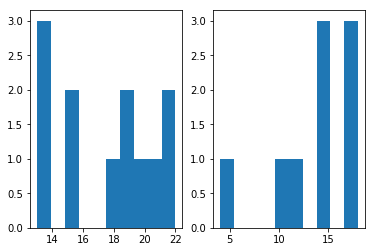

In [12]:
pylab.subplot(1, 2, 1)
pylab.hist(data1)
pylab.subplot(1, 2, 2)
pylab.hist(data2)

In [13]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
df = pd.read_csv('challenger.txt', header=0, sep='\t')

In [15]:
df.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [20]:
data1 = np.array(df[df.Incident == 0].Temperature)
data1

array([18.9, 20.6, 20. , 19.4, 22.2, 22.8, 21.1, 25.6, 19.4, 19.4, 23.9,
       21.1, 27.2, 24.4, 26.1, 24.4])

In [21]:
data2 = np.array(df[df.Incident == 1].Temperature)
data2

array([21.1, 13.9, 17.2, 21.1, 11.7, 23.9, 14.4])

In [33]:
data1.mean() - data2.mean()

4.666964285714283

In [34]:
np.random.seed(0)

In [35]:
samples1 = get_bootstrap_samples(data1, 1000)
samples2 = get_bootstrap_samples(data2, 1000)

data = [x.mean() - y.mean() for x, y in zip(samples1, samples2)]
data

[3.7937499999999993,
 4.061607142857142,
 1.9758928571428527,
 5.021428571428572,
 2.060714285714287,
 3.5625,
 5.93928571428571,
 4.0598214285714285,
 6.991964285714287,
 3.626785714285713,
 4.002678571428568,
 3.610714285714284,
 3.6223214285714285,
 5.311607142857142,
 5.767857142857142,
 4.524107142857144,
 2.181250000000002,
 4.825892857142858,
 6.1303571428571395,
 3.0785714285714256,
 4.698214285714286,
 4.154464285714287,
 1.446428571428573,
 4.129464285714285,
 4.832142857142859,
 3.6562499999999964,
 3.6687499999999957,
 5.511607142857137,
 2.3357142857142854,
 2.7285714285714278,
 1.0446428571428577,
 7.4625,
 4.142857142857142,
 0.9883928571428555,
 5.870535714285715,
 3.8580357142857125,
 2.674107142857139,
 3.2633928571428577,
 6.28303571428571,
 3.473214285714281,
 4.790178571428569,
 4.858035714285709,
 4.210714285714282,
 4.082142857142852,
 1.5901785714285737,
 5.731249999999999,
 5.93392857142857,
 4.282142857142862,
 3.6517857142857153,
 4.039285714285718,
 3.690178

In [36]:
stat_intervals(data, 0.05)

array([1.42299107, 7.93861607])

In [31]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [32]:
np.random.seed(0)

permutation_test(data1, data2, max_permutations=10000, alternative='two-sided')

0.007